# Model creation

Use this notebook to create a model using a specific method

- [Polynomial regression](#polynomial-regression)
- [Gradient boosted decision trees](#gradient-boosted-decision-trees)

# Setup

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import common_functions as cf

import importlib

importlib.reload(cf)

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
ARRAY_SIZE = ARRAY_W * ARRAY_H
NAME_PREFIX = "H1_5_s"
MODEL_NAME = "H1_5-2x2"
# NAMES = [f"H1_5_s{i}" for i in range(ARRAY_SIZE)]


In [2]:
NAMES = [f"{NAME_PREFIX}{i}" for i in range(ARRAY_SIZE)]
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

all_data = []

# Loading data (but not in 1 pd.DataFrame)
for i, name in enumerate(NAMES):
    TFdata = cf.read_csv_file(f"../scripts/FT300-S_force_torque/data/{name}.csv") 
    sensordata = cf.read_csv_file(f'../scripts/2x2_sensor/data/{name}.csv')
    
    # Time sync
    data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

    # Remove mean of first 100 samples
    data = cf.offset_data(data, data_columns, 100)
    
    # Remove rows containing NaN values
    data = data.dropna()
    
    # Add X, Y, Z columns to avoid confusion
    data['X'] = (data[f'X{i}'])
    data['Y'] = (data[f'Y{i}'])
    data['Z'] = (data[f'Z{i}'])
    
    # Remove other columns
    data = data.drop(columns=data_columns)

    all_data.append(data)

print("Data loaded. Taxel 0 sensor test")
all_data[0].info()

Data loaded. Taxel 0 sensor test
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9038 entries, 1 to 9038
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    9038 non-null   int64  
 1   t_wall   9038 non-null   float64
 2   t_robot  9038 non-null   float64
 3   F_x      9038 non-null   float64
 4   F_y      9038 non-null   float64
 5   F_z      9038 non-null   float64
 6   T_x      9038 non-null   float64
 7   T_y      9038 non-null   float64
 8   T_z      9038 non-null   float64
 9   X        9038 non-null   float64
 10  Y        9038 non-null   float64
 11  Z        9038 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 917.9 KB


In [3]:
for j in range(ARRAY_SIZE):
    data = all_data[j]
    
    data['F_xy'] = np.sqrt(data['F_x']**2 + data['F_y']**2)
    data['F_m'] = np.sqrt(data['F_x']**2 + data['F_y']**2 + data['F_z']**2)
    
    data[f'XY'] = np.sqrt(data[f'X']**2 + data[f'Y']**2)
    data[f'M'] = np.sqrt(data[f'X']**2 + data[f'Y']**2 + data[f'Z']**2)

In [4]:
def simulate_forces(taxel_models):
  # Simulate forces to plot model

  for j, letter in enumerate(['X', 'Y', 'Z']):

      fig = plt.figure()
      gs = fig.add_gridspec(ARRAY_H, ARRAY_W)
      axs = cf.flatten_extend(gs.subplots())

      for i, model in enumerate(taxel_models):

          data = all_data[i]

          ax = axs[i]
          
          # Simulate force
          X = np.zeros((100, 3))
          X[:, j] = np.linspace(min(data[letter]), max(data[letter]), 100)
          
          Y = model.predict(X)

          ax.plot(X[:, j], Y[:, j], label='Model Function')
          ax.scatter(data[letter], data[f'F_{letter.lower()}'], label='Data', s=0.05, c='r')

      plt.show()


In [5]:
# Save taxel models (per taxel)
import dill

def save_taxel_models(taxel_models, subdir, name):
  save_path = os.path.join(os.getcwd(), '..', 'models', subdir)

  if not os.path.exists(save_path):
      os.makedirs(save_path)
      
  with open(os.path.join(save_path, name), 'wb') as f:
      dill.dump(taxel_models, f)
    

# Polynomial regression

Calibration achieved by pressing on all taxel one-by-one without silicone layer

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

set_config(display='diagram')

POLY_DEGREE = 4

def create_regression_pipeline_and_fit(X, Y, debug = True):
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

  pipeline = make_pipeline(
    PolynomialFeatures(degree=POLY_DEGREE, include_bias=False), 
    LinearRegression()
  )
  
  pipeline.fit(X_train, y_train)

  if debug:
    
    print("Score: ", pipeline.score(X_test, y_test))
    print("MSE: ", mean_squared_error(y_test, pipeline.predict(X_test)))
  
  return pipeline

class CombinedModel:
  
  def __init__(self, component_models) -> None:
    self.component_models = component_models
    
  def predict(self, X):
    
    predictions = []
    
    for i, model in enumerate(self.component_models):
      predictions.append(model.predict(X[:, i].reshape(-1, 1))[:, 0])
    
    return np.array(predictions).T

In [17]:
taxel_models = []

for i in range(ARRAY_SIZE):

    data = all_data[i]
    
    component_models = []
    for letter in ['X', 'Y', 'Z']:
        
        print(f"\nTaxel {i}, {letter}")
        
        X = data[[letter]]
        Y = data[[f'F_{letter.lower()}']]
    
        print(Y.shape, X.shape)
    
        component_model = create_regression_pipeline_and_fit(X, Y)
        component_models.append(component_model)
    
    taxel_models.append(CombinedModel(component_models))


Taxel 0, X
(9038, 1) (9038, 1)
Score:  0.7072474202308485
MSE:  0.15271497270040635

Taxel 0, Y
(9038, 1) (9038, 1)
Score:  0.5068340964366124
MSE:  0.14986444914710317

Taxel 0, Z
(9038, 1) (9038, 1)
Score:  0.9270742754373079
MSE:  0.4914853772755326

Taxel 1, X
(28571, 1) (28571, 1)
Score:  0.3328533524886249
MSE:  0.04764393972723016

Taxel 1, Y
(28571, 1) (28571, 1)
Score:  0.3452096223496831
MSE:  0.07246939278479471

Taxel 1, Z
(28571, 1) (28571, 1)
Score:  0.916837164151767
MSE:  0.3757140721544788

Taxel 2, X
(21296, 1) (21296, 1)
Score:  0.831102623194085
MSE:  0.024548387958905862

Taxel 2, Y
(21296, 1) (21296, 1)
Score:  0.3424692036732343
MSE:  0.036654971623296374

Taxel 2, Z
(21296, 1) (21296, 1)
Score:  0.9813636897994688
MSE:  0.0645457284694051

Taxel 3, X
(18528, 1) (18528, 1)
Score:  0.6565892930788861
MSE:  0.017664250582075845

Taxel 3, Y
(18528, 1) (18528, 1)
Score:  0.8671240776665378
MSE:  0.022273952323546536

Taxel 3, Z
(18528, 1) (18528, 1)
Score:  0.793961

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/s

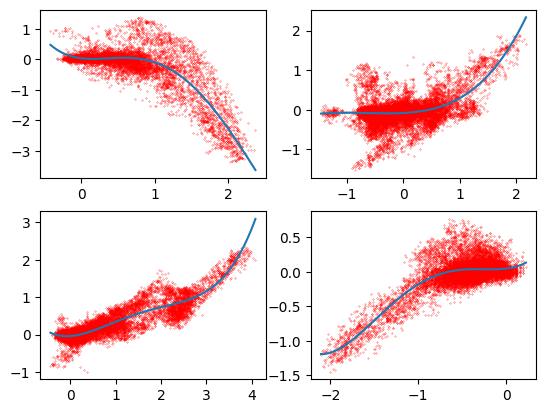

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/s

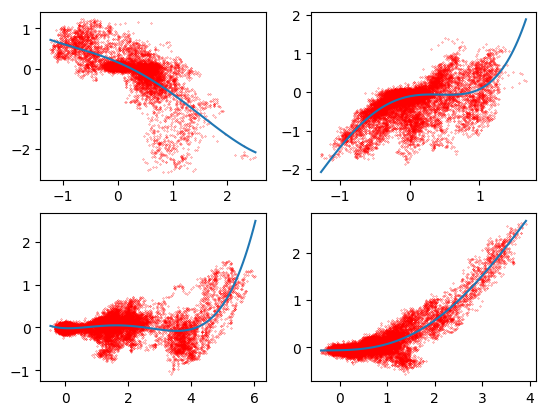

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/s

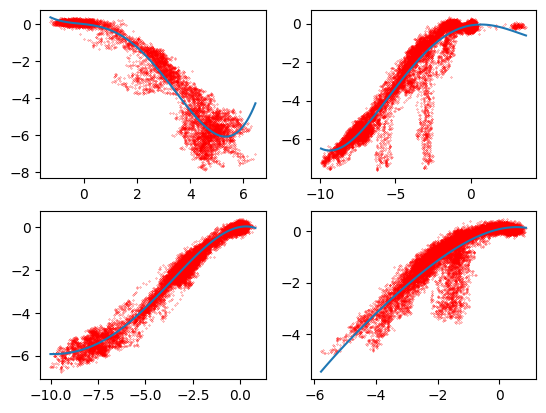

In [17]:
simulate_forces(taxel_models)

In [23]:
save_taxel_models(taxel_models, F'PolyLinear-Deg{POLY_DEGREE}', MODEL_NAME)

# Gradient boosted decision trees

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
class CombinedModelGDBT:
  
  def __init__(self, component_models) -> None:
    self.component_models = component_models
    
  def predict(self, X):
    
    predictions = []
    
    for i, model in enumerate(self.component_models):
      predictions.append(model.predict(X))
    
    return np.array(predictions).T

In [23]:
taxel_models = []
columns = ['F_x', 'F_y', 'F_z']

param_grid = {
    "max_depth": [1, 2, 4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 5),
}

for i in range(ARRAY_SIZE):
  
  data = all_data[i]
  
  component_models = []
  
  print(f"\nTaxel {i}")
  
  for col in columns:
    
    # (Train/val) / test split
    X = data[['X', 'Y', 'Z']]
    y = data[[col]]

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, shuffle=True)

    reg = HistGradientBoostingRegressor()

    gridsearch = GridSearchCV(reg, param_grid=param_grid, verbose=1, return_train_score=True, n_jobs=8)

    gridsearch.fit(X_train, y_train[:, 0])  
    
    print("Score: ", gridsearch.best_estimator_.score(X_test, y_test))
    
    component_models.append(gridsearch.best_estimator_)
    
  taxel_models.append(CombinedModelGDBT(component_models))


Taxel 0
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9284105770965261
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8207700205131018
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9786542057026573

Taxel 1
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8286420323327727
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8519166047225301
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9765049151303316

Taxel 2
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9404787098984293
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8868665554279788
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9941152256723282

Taxel 3
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8760352732550875
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.96

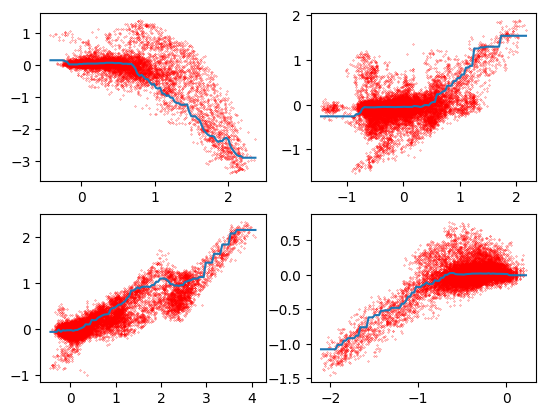

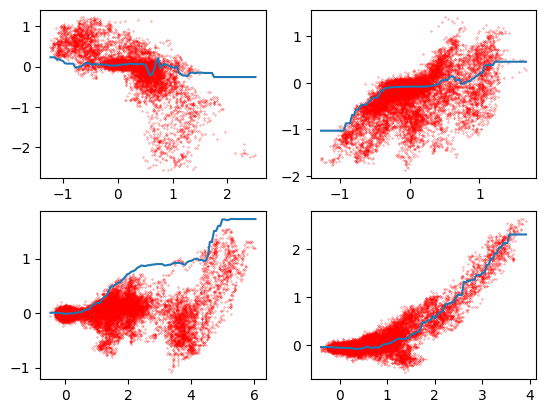

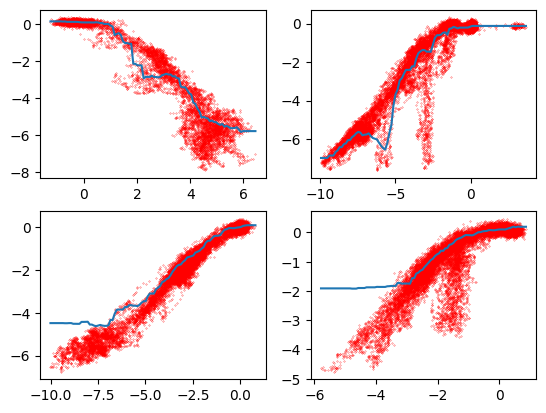

In [24]:
simulate_forces(taxel_models)

In [25]:
save_taxel_models(taxel_models, 'GBDT', MODEL_NAME)